# Convolutional Neural Network

The last method we cover, is the convolutional neural network. We have chosen to implement the CNN called LeNet. LeNet has the structure below. LeNet takes a 28x28 greyscale image, and runs it sequentially through two convolution layers (each consisting of a convolution, an activation function and a pooling layer.). The second convolutional layer feeds the output to a fully connected neural network. In our implementation, we also introduce a dropout layer after the first fully connected layer. This prevents overfitting. Furthermore we also do early stopping to prevent overfitting on the training dataset.


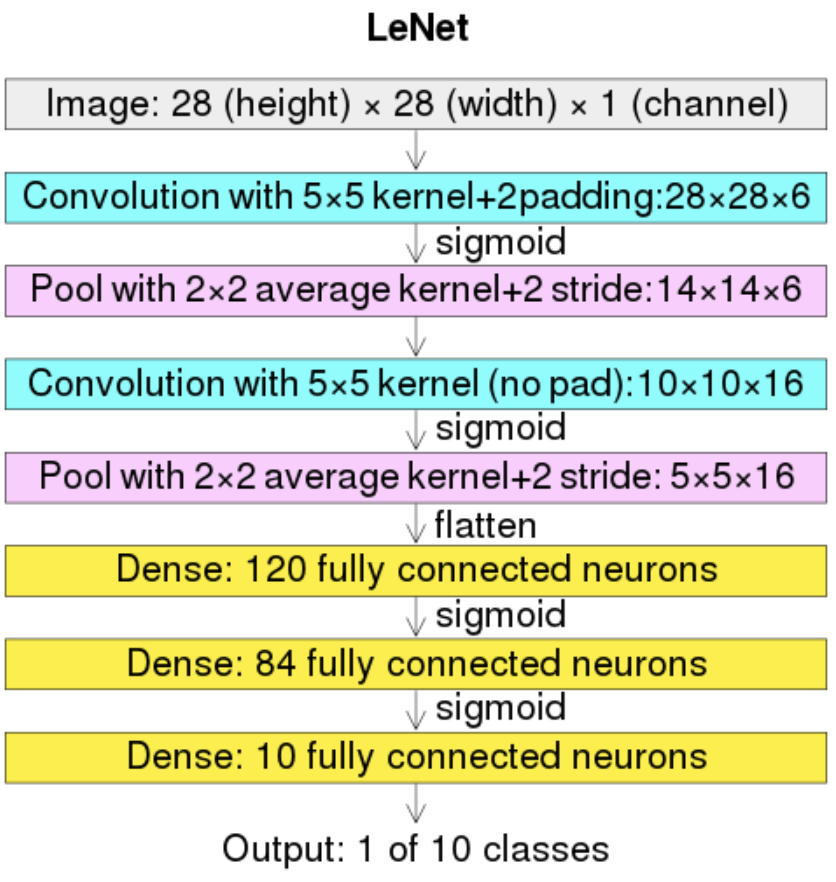

In [289]:
# Libaries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sns.set_style("darkgrid")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torchinfo import summary
import torchvision



from sklearn.metrics import *


In [249]:
# Load data

train_data = np.load("data/fashion_train.npy")
X_train, y_train = train_data[:,:784] / 255, train_data[:,-1]

test_data = np.load("data/fashion_test.npy")
X_test, y_test = test_data[:,:784] / 255, test_data[:,-1]

N_CLASSES = len(np.unique(y_train))
CLOTHING_TYPES = {0: "T-shirt/top", 
                  1: "Trouser",
                  2: "Pullover",
                  3: "Dress",
                  4: "Shirt"}


To allow early stopping, we split the dataset into training, validation and test dataset. These consist of 53.3%, 13.3% and 33.3%

In [250]:
cnn_X_train = X_train.reshape(-1,28,28)
X_tensor = torch.from_numpy(cnn_X_train).float().unsqueeze(1)
y_tensor = torch.from_numpy(y_train).long()
cnn_train_data = TensorDataset(X_tensor, y_tensor)

cnn_X_test = X_test.reshape(-1,28,28)
X_test_tensor = torch.from_numpy(cnn_X_test).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).long()
cnn_test_data = TensorDataset(X_test_tensor, y_test_tensor)

cnn_train_data, cnn_validation_data = torch.utils.data.random_split(cnn_train_data, [8000, 2000]) 

In [251]:
# We create a dataloader for train and test
BATCH_SIZE = 128

loaders = {
    'train' : DataLoader(cnn_train_data,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
        
    'validation'  : DataLoader(cnn_validation_data, 
                                          batch_size=BATCH_SIZE,
                                          num_workers=1,
                                          ),

    'test'  : DataLoader(cnn_test_data, 
                                          batch_size=BATCH_SIZE, 
                                          num_workers=1,
                                          )
}


In [323]:
# We define the LeNet

class CNN(nn.Module):
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []
        self.n_epochs = 0

        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5, padding=2), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5), 
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2)
        )

        self.fully_connected = nn.Sequential(
            # FFNN Layer 1
            nn.Linear(in_features=16*5*5,out_features=120), 
            nn.Sigmoid(),
            nn.Dropout(p=0.2),

            # FFNN Layer 2
            nn.Linear(in_features=120,out_features=84), 
            nn.Sigmoid(),
            
            # FFNN Output layer
            nn.Linear(in_features=84,out_features=N_CLASSES) 
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.fully_connected(x)
        return output
    
    def plot_loss(self):
        sns.lineplot(x=[i for i in range(1,self.n_epochs + 1)], y=conv_nn.training_loss, marker='o',color="red",label='Training loss')
        sns.lineplot(x=[i for i in range(1,self.n_epochs + 1)], y=conv_nn.validation_loss,marker='o', color="blue", label='Validation loss')
        plt.legend()
        plt.suptitle("Training and validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.tight_layout()


# initialise it
conv_nn = CNN()


def train(n_epochs, ann, loaders, learning_rate=0.05):
    ann.n_epochs = n_epochs
    ann.validation_loss = []
    ann.training_loss = []
    min_valid_loss = np.inf
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    ann.to(device)

    for epoch in tqdm(range(n_epochs)):
        epoch_train_loss = 0
        ann.train()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(ann.parameters(), lr=learning_rate)

        for i, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device)
            
            output = ann(images)

            loss = loss_fn(output, labels)
            epoch_train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        epoch_val_loss = 0
        ann.eval()

        for images_v, labels_v in loaders['validation']:
            images_v, labels_v = images_v.to(device), labels_v.to(device)

            output = ann(images_v)
            loss_v = loss_fn(output, labels_v)
            epoch_val_loss += loss_v.item()
        
        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')

        ann.validation_loss.append(epoch_val_loss / len(loaders["validation"]))
        ann.training_loss.append(epoch_train_loss / len(loaders["train"]))

        print('-------------------')
        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss/ len(loaders["validation"])}--->{epoch_val_loss/ len(loaders["validation"])}) \t Saving The Model')
            min_valid_loss = epoch_val_loss
          # Saving State Dict
            torch.save(ann.state_dict(), 'data/saved_model.pth')

summary(conv_nn,input_size=[8000,1,28,28])



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [8000, 5]                 --
├─Sequential: 1-1                        [8000, 6, 14, 14]         --
│    └─Conv2d: 2-1                       [8000, 6, 28, 28]         156
│    └─Sigmoid: 2-2                      [8000, 6, 28, 28]         --
│    └─AvgPool2d: 2-3                    [8000, 6, 14, 14]         --
├─Sequential: 1-2                        [8000, 16, 5, 5]          --
│    └─Conv2d: 2-4                       [8000, 16, 10, 10]        2,416
│    └─Sigmoid: 2-5                      [8000, 16, 10, 10]        --
│    └─AvgPool2d: 2-6                    [8000, 16, 5, 5]          --
├─Sequential: 1-3                        [8000, 5]                 --
│    └─Linear: 2-7                       [8000, 120]               48,120
│    └─Sigmoid: 2-8                      [8000, 120]               --
│    └─Dropout: 2-9                      [8000, 120]               --
│    └─

In [324]:
train(100, conv_nn, loaders, 0.005)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:46,  2.90s/it]

Epoch 1
Training Loss: 1.5881533055078416
Validation Loss: 1.4134973213076591
-------------------
Validation Loss Decreased(inf--->1.4134973213076591) 	 Saving The Model


  2%|▏         | 2/100 [00:05<04:22,  2.68s/it]

Epoch 2
Training Loss: 1.1061214255908178
Validation Loss: 0.9242192357778549
-------------------
Validation Loss Decreased(1.4134973213076591--->0.9242192357778549) 	 Saving The Model


  3%|▎         | 3/100 [00:08<04:17,  2.66s/it]

Epoch 3
Training Loss: 0.9293754895528158
Validation Loss: 0.844932921230793
-------------------
Validation Loss Decreased(0.9242192357778549--->0.844932921230793) 	 Saving The Model


  4%|▍         | 4/100 [00:10<04:20,  2.71s/it]

Epoch 4
Training Loss: 0.8447498366946266
Validation Loss: 0.7640454769134521
-------------------
Validation Loss Decreased(0.844932921230793--->0.7640454769134521) 	 Saving The Model


  5%|▌         | 5/100 [00:13<04:11,  2.65s/it]

Epoch 5
Training Loss: 0.7759610707797702
Validation Loss: 0.6919862553477287
-------------------
Validation Loss Decreased(0.7640454769134521--->0.6919862553477287) 	 Saving The Model


  6%|▌         | 6/100 [00:15<04:05,  2.61s/it]

Epoch 6
Training Loss: 0.7054455800661965
Validation Loss: 0.6429684050381184
-------------------
Validation Loss Decreased(0.6919862553477287--->0.6429684050381184) 	 Saving The Model


  7%|▋         | 7/100 [00:18<04:03,  2.62s/it]

Epoch 7
Training Loss: 0.6582227510119242
Validation Loss: 0.6198335308581591
-------------------
Validation Loss Decreased(0.6429684050381184--->0.6198335308581591) 	 Saving The Model


  8%|▊         | 8/100 [00:21<04:01,  2.63s/it]

Epoch 8
Training Loss: 0.619904617468516
Validation Loss: 0.5666404273360968
-------------------
Validation Loss Decreased(0.6198335308581591--->0.5666404273360968) 	 Saving The Model


  9%|▉         | 9/100 [00:23<03:57,  2.61s/it]

Epoch 9
Training Loss: 0.5842573898179191
Validation Loss: 0.5527381766587496
-------------------
Validation Loss Decreased(0.5666404273360968--->0.5527381766587496) 	 Saving The Model


 10%|█         | 10/100 [00:26<03:50,  2.57s/it]

Epoch 10
Training Loss: 0.5665980274715121
Validation Loss: 0.5456706285476685
-------------------
Validation Loss Decreased(0.5527381766587496--->0.5456706285476685) 	 Saving The Model


 11%|█         | 11/100 [00:28<03:49,  2.58s/it]

Epoch 11
Training Loss: 0.5412107994632115
Validation Loss: 0.5042445994913578
-------------------
Validation Loss Decreased(0.5456706285476685--->0.5042445994913578) 	 Saving The Model


 12%|█▏        | 12/100 [00:31<03:52,  2.64s/it]

Epoch 12
Training Loss: 0.5283265747721233
Validation Loss: 0.5012264046818018
-------------------
Validation Loss Decreased(0.5042445994913578--->0.5012264046818018) 	 Saving The Model


 13%|█▎        | 13/100 [00:34<03:50,  2.65s/it]

Epoch 13
Training Loss: 0.5190364850891961
Validation Loss: 0.49482971616089344
-------------------
Validation Loss Decreased(0.5012264046818018--->0.49482971616089344) 	 Saving The Model


 14%|█▍        | 14/100 [00:36<03:48,  2.65s/it]

Epoch 14
Training Loss: 0.5007769895924462
Validation Loss: 0.4888731222599745
-------------------
Validation Loss Decreased(0.49482971616089344--->0.4888731222599745) 	 Saving The Model


 15%|█▌        | 15/100 [00:39<03:43,  2.62s/it]

Epoch 15
Training Loss: 0.4878752217406318
Validation Loss: 0.4567957688122988
-------------------
Validation Loss Decreased(0.4888731222599745--->0.4567957688122988) 	 Saving The Model


 16%|█▌        | 16/100 [00:42<03:41,  2.64s/it]

Epoch 16
Training Loss: 0.4751452515049586
Validation Loss: 0.483669925481081
-------------------


 17%|█▋        | 17/100 [00:44<03:37,  2.62s/it]

Epoch 17
Training Loss: 0.46270105006202816
Validation Loss: 0.4444074295461178
-------------------
Validation Loss Decreased(0.4567957688122988--->0.4444074295461178) 	 Saving The Model


 18%|█▊        | 18/100 [00:47<03:29,  2.56s/it]

Epoch 18
Training Loss: 0.45195558903709293
Validation Loss: 0.4561622105538845
-------------------


 19%|█▉        | 19/100 [00:49<03:26,  2.55s/it]

Epoch 19
Training Loss: 0.44241506665472
Validation Loss: 0.416588531807065
-------------------
Validation Loss Decreased(0.4444074295461178--->0.416588531807065) 	 Saving The Model


 20%|██        | 20/100 [00:52<03:21,  2.51s/it]

Epoch 20
Training Loss: 0.43646481775102164
Validation Loss: 0.4079862032085657
-------------------
Validation Loss Decreased(0.416588531807065--->0.4079862032085657) 	 Saving The Model


 21%|██        | 21/100 [00:54<03:16,  2.49s/it]

Epoch 21
Training Loss: 0.4286322219977303
Validation Loss: 0.3950868658721447
-------------------
Validation Loss Decreased(0.4079862032085657--->0.3950868658721447) 	 Saving The Model


 22%|██▏       | 22/100 [00:57<03:13,  2.48s/it]

Epoch 22
Training Loss: 0.4145277445278471
Validation Loss: 0.39231344126164913
-------------------
Validation Loss Decreased(0.3950868658721447--->0.39231344126164913) 	 Saving The Model


 23%|██▎       | 23/100 [00:59<03:08,  2.45s/it]

Epoch 23
Training Loss: 0.4089653756883409
Validation Loss: 0.37754577584564686
-------------------
Validation Loss Decreased(0.39231344126164913--->0.37754577584564686) 	 Saving The Model


 24%|██▍       | 24/100 [01:01<03:05,  2.43s/it]

Epoch 24
Training Loss: 0.40166170871447004
Validation Loss: 0.39518202282488346
-------------------


 25%|██▌       | 25/100 [01:04<03:02,  2.43s/it]

Epoch 25
Training Loss: 0.38603918845691376
Validation Loss: 0.37030218727886677
-------------------
Validation Loss Decreased(0.37754577584564686--->0.37030218727886677) 	 Saving The Model


 26%|██▌       | 26/100 [01:06<03:00,  2.43s/it]

Epoch 26
Training Loss: 0.3888014063002571
Validation Loss: 0.3616210073232651
-------------------
Validation Loss Decreased(0.37030218727886677--->0.3616210073232651) 	 Saving The Model


 27%|██▋       | 27/100 [01:09<03:01,  2.49s/it]

Epoch 27
Training Loss: 0.37617859670094084
Validation Loss: 0.35930696688592434
-------------------
Validation Loss Decreased(0.3616210073232651--->0.35930696688592434) 	 Saving The Model


 28%|██▊       | 28/100 [01:11<03:02,  2.53s/it]

Epoch 28
Training Loss: 0.37167185071914915
Validation Loss: 0.3670872934162617
-------------------


 29%|██▉       | 29/100 [01:14<03:01,  2.56s/it]

Epoch 29
Training Loss: 0.36710534682349555
Validation Loss: 0.3722297102212906
-------------------


 30%|███       | 30/100 [01:17<02:57,  2.54s/it]

Epoch 30
Training Loss: 0.35737450964867123
Validation Loss: 0.338430461473763
-------------------
Validation Loss Decreased(0.35930696688592434--->0.338430461473763) 	 Saving The Model


 31%|███       | 31/100 [01:19<02:55,  2.54s/it]

Epoch 31
Training Loss: 0.3537900868862394
Validation Loss: 0.33911755681037903
-------------------


 32%|███▏      | 32/100 [01:22<02:52,  2.54s/it]

Epoch 32
Training Loss: 0.34271072040474604
Validation Loss: 0.33777205646038055
-------------------
Validation Loss Decreased(0.338430461473763--->0.33777205646038055) 	 Saving The Model


 33%|███▎      | 33/100 [01:24<02:51,  2.56s/it]

Epoch 33
Training Loss: 0.3421191703232508
Validation Loss: 0.33519795164465904
-------------------
Validation Loss Decreased(0.33777205646038055--->0.33519795164465904) 	 Saving The Model


 34%|███▍      | 34/100 [01:27<02:47,  2.54s/it]

Epoch 34
Training Loss: 0.3333727589675358
Validation Loss: 0.35480056144297123
-------------------


 35%|███▌      | 35/100 [01:29<02:45,  2.55s/it]

Epoch 35
Training Loss: 0.32735255265992785
Validation Loss: 0.33089811634272337
-------------------
Validation Loss Decreased(0.33519795164465904--->0.33089811634272337) 	 Saving The Model


 36%|███▌      | 36/100 [01:32<02:40,  2.50s/it]

Epoch 36
Training Loss: 0.319107600147762
Validation Loss: 0.3272670703008771
-------------------
Validation Loss Decreased(0.33089811634272337--->0.3272670703008771) 	 Saving The Model


 37%|███▋      | 37/100 [01:34<02:35,  2.48s/it]

Epoch 37
Training Loss: 0.32000595189276193
Validation Loss: 0.34780034609138966
-------------------


 38%|███▊      | 38/100 [01:36<02:32,  2.45s/it]

Epoch 38
Training Loss: 0.3166172504425049
Validation Loss: 0.3250072542577982
-------------------
Validation Loss Decreased(0.3272670703008771--->0.3250072542577982) 	 Saving The Model


 39%|███▉      | 39/100 [01:39<02:28,  2.44s/it]

Epoch 39
Training Loss: 0.31269796500130304
Validation Loss: 0.3279229998588562
-------------------


 40%|████      | 40/100 [01:41<02:25,  2.42s/it]

Epoch 40
Training Loss: 0.3032833340149077
Validation Loss: 0.31398272048681974
-------------------
Validation Loss Decreased(0.3250072542577982--->0.31398272048681974) 	 Saving The Model


 41%|████      | 41/100 [01:44<02:21,  2.40s/it]

Epoch 41
Training Loss: 0.2979558008530783
Validation Loss: 0.32974413502961397
-------------------


 42%|████▏     | 42/100 [01:46<02:18,  2.39s/it]

Epoch 42
Training Loss: 0.2995519153182469
Validation Loss: 0.3156932666897774
-------------------


 43%|████▎     | 43/100 [01:48<02:16,  2.40s/it]

Epoch 43
Training Loss: 0.2913562170569859
Validation Loss: 0.36067773774266243
-------------------


 44%|████▍     | 44/100 [01:51<02:14,  2.41s/it]

Epoch 44
Training Loss: 0.28641584066171494
Validation Loss: 0.3176651895046234
-------------------


 45%|████▌     | 45/100 [01:53<02:13,  2.42s/it]

Epoch 45
Training Loss: 0.2805935298166578
Validation Loss: 0.3217771789059043
-------------------


 46%|████▌     | 46/100 [01:56<02:11,  2.44s/it]

Epoch 46
Training Loss: 0.27564976707337396
Validation Loss: 0.30881842598319054
-------------------
Validation Loss Decreased(0.31398272048681974--->0.30881842598319054) 	 Saving The Model


 47%|████▋     | 47/100 [01:58<02:10,  2.47s/it]

Epoch 47
Training Loss: 0.2781726046214028
Validation Loss: 0.31459410581737757
-------------------


 48%|████▊     | 48/100 [02:01<02:08,  2.47s/it]

Epoch 48
Training Loss: 0.27606932866194894
Validation Loss: 0.3297088276594877
-------------------


 49%|████▉     | 49/100 [02:03<02:04,  2.44s/it]

Epoch 49
Training Loss: 0.2705955169503651
Validation Loss: 0.32145644817501307
-------------------


 50%|█████     | 50/100 [02:06<02:01,  2.43s/it]

Epoch 50
Training Loss: 0.2795674642400136
Validation Loss: 0.3043711883947253
-------------------
Validation Loss Decreased(0.30881842598319054--->0.3043711883947253) 	 Saving The Model


 51%|█████     | 51/100 [02:08<01:59,  2.45s/it]

Epoch 51
Training Loss: 0.25579146047433216
Validation Loss: 0.30835033766925335
-------------------


 52%|█████▏    | 52/100 [02:10<01:57,  2.44s/it]

Epoch 52
Training Loss: 0.2531011708908611
Validation Loss: 0.3165658861398697
-------------------


 53%|█████▎    | 53/100 [02:13<01:53,  2.42s/it]

Epoch 53
Training Loss: 0.25424327949682873
Validation Loss: 0.3248953213915229
-------------------


 54%|█████▍    | 54/100 [02:15<01:51,  2.43s/it]

Epoch 54
Training Loss: 0.25086998892208884
Validation Loss: 0.2911770697683096
-------------------
Validation Loss Decreased(0.3043711883947253--->0.2911770697683096) 	 Saving The Model


 55%|█████▌    | 55/100 [02:18<01:48,  2.41s/it]

Epoch 55
Training Loss: 0.24669657742220258
Validation Loss: 0.3194731241092086
-------------------


 56%|█████▌    | 56/100 [02:20<01:46,  2.41s/it]

Epoch 56
Training Loss: 0.24839011544273012
Validation Loss: 0.31063406355679035
-------------------


 57%|█████▋    | 57/100 [02:22<01:43,  2.41s/it]

Epoch 57
Training Loss: 0.23013022944094644
Validation Loss: 0.3067708080634475
-------------------


 58%|█████▊    | 58/100 [02:25<01:40,  2.40s/it]

Epoch 58
Training Loss: 0.23264041353785803
Validation Loss: 0.31892939656972885
-------------------


 59%|█████▉    | 59/100 [02:27<01:38,  2.41s/it]

Epoch 59
Training Loss: 0.22718280411901928
Validation Loss: 0.32121284026652575
-------------------


 60%|██████    | 60/100 [02:30<01:36,  2.41s/it]

Epoch 60
Training Loss: 0.23341852095392016
Validation Loss: 0.34364789072424173
-------------------


 61%|██████    | 61/100 [02:32<01:33,  2.39s/it]

Epoch 61
Training Loss: 0.22806566291385227
Validation Loss: 0.31878607254475355
-------------------


 62%|██████▏   | 62/100 [02:34<01:30,  2.39s/it]

Epoch 62
Training Loss: 0.21898186821786184
Validation Loss: 0.3324785577133298
-------------------


 63%|██████▎   | 63/100 [02:37<01:28,  2.40s/it]

Epoch 63
Training Loss: 0.21575982419271317
Validation Loss: 0.31160438247025013
-------------------


 64%|██████▍   | 64/100 [02:39<01:26,  2.41s/it]

Epoch 64
Training Loss: 0.2124259803030226
Validation Loss: 0.32650019600987434
-------------------


 65%|██████▌   | 65/100 [02:42<01:24,  2.42s/it]

Epoch 65
Training Loss: 0.21760500660018314
Validation Loss: 0.32497166004031897
-------------------


 66%|██████▌   | 66/100 [02:44<01:21,  2.41s/it]

Epoch 66
Training Loss: 0.20817248062008903
Validation Loss: 0.3147827098146081
-------------------


 67%|██████▋   | 67/100 [02:47<01:20,  2.42s/it]

Epoch 67
Training Loss: 0.20574500494533116
Validation Loss: 0.3248481284826994
-------------------


 68%|██████▊   | 68/100 [02:49<01:17,  2.43s/it]

Epoch 68
Training Loss: 0.2001248239761307
Validation Loss: 0.3489297339692712
-------------------


 69%|██████▉   | 69/100 [02:51<01:14,  2.41s/it]

Epoch 69
Training Loss: 0.20114208556829938
Validation Loss: 0.32516919635236263
-------------------


 70%|███████   | 70/100 [02:54<01:12,  2.41s/it]

Epoch 70
Training Loss: 0.1989379364346701
Validation Loss: 0.3337929993867874
-------------------


 71%|███████   | 71/100 [02:56<01:10,  2.44s/it]

Epoch 71
Training Loss: 0.19441603088662737
Validation Loss: 0.33614054694771767
-------------------


 72%|███████▏  | 72/100 [02:59<01:08,  2.43s/it]

Epoch 72
Training Loss: 0.19457073012987772
Validation Loss: 0.3191926805302501
-------------------


 73%|███████▎  | 73/100 [03:01<01:05,  2.43s/it]

Epoch 73
Training Loss: 0.18167640186018413
Validation Loss: 0.32770813163369894
-------------------


 74%|███████▍  | 74/100 [03:04<01:02,  2.41s/it]

Epoch 74
Training Loss: 0.176926636033588
Validation Loss: 0.33180748019367456
-------------------


 75%|███████▌  | 75/100 [03:06<00:59,  2.40s/it]

Epoch 75
Training Loss: 0.18477199072875675
Validation Loss: 0.3315101871266961
-------------------


 76%|███████▌  | 76/100 [03:08<00:57,  2.39s/it]

Epoch 76
Training Loss: 0.17196536667290188
Validation Loss: 0.3591083390638232
-------------------


 77%|███████▋  | 77/100 [03:11<00:55,  2.41s/it]

Epoch 77
Training Loss: 0.17075178606642616
Validation Loss: 0.33932963851839304
-------------------


 78%|███████▊  | 78/100 [03:13<00:53,  2.41s/it]

Epoch 78
Training Loss: 0.16345020501859606
Validation Loss: 0.35082271602004766
-------------------


 79%|███████▉  | 79/100 [03:16<00:50,  2.40s/it]

Epoch 79
Training Loss: 0.1604046327254129
Validation Loss: 0.3440234726294875
-------------------


 80%|████████  | 80/100 [03:18<00:47,  2.38s/it]

Epoch 80
Training Loss: 0.17491646252927326
Validation Loss: 0.3444718373939395
-------------------


 81%|████████  | 81/100 [03:20<00:45,  2.38s/it]

Epoch 81
Training Loss: 0.16326433077218042
Validation Loss: 0.349844116717577
-------------------


 82%|████████▏ | 82/100 [03:23<00:42,  2.38s/it]

Epoch 82
Training Loss: 0.15645751652736511
Validation Loss: 0.34362151101231575
-------------------


 83%|████████▎ | 83/100 [03:25<00:40,  2.38s/it]

Epoch 83
Training Loss: 0.16060449786129452
Validation Loss: 0.3582743750885129
-------------------


 84%|████████▍ | 84/100 [03:27<00:38,  2.39s/it]

Epoch 84
Training Loss: 0.15761902360689073
Validation Loss: 0.35197096131742
-------------------


 85%|████████▌ | 85/100 [03:30<00:36,  2.43s/it]

Epoch 85
Training Loss: 0.14829280960654456
Validation Loss: 0.35620952770113945
-------------------


 86%|████████▌ | 86/100 [03:32<00:33,  2.41s/it]

Epoch 86
Training Loss: 0.15669073980479015
Validation Loss: 0.37557704374194145
-------------------


 87%|████████▋ | 87/100 [03:35<00:31,  2.39s/it]

Epoch 87
Training Loss: 0.14726020573150544
Validation Loss: 0.3579725278541446
-------------------


 88%|████████▊ | 88/100 [03:37<00:28,  2.40s/it]

Epoch 88
Training Loss: 0.14524340854277687
Validation Loss: 0.36899945605546236
-------------------


 89%|████████▉ | 89/100 [03:40<00:26,  2.43s/it]

Epoch 89
Training Loss: 0.14403091974201657
Validation Loss: 0.3769065449014306
-------------------


 90%|█████████ | 90/100 [03:42<00:24,  2.43s/it]

Epoch 90
Training Loss: 0.1456555182498599
Validation Loss: 0.38141951989382505
-------------------


 91%|█████████ | 91/100 [03:44<00:21,  2.42s/it]

Epoch 91
Training Loss: 0.14038643589805042
Validation Loss: 0.3676872458308935
-------------------


 92%|█████████▏| 92/100 [03:47<00:19,  2.42s/it]

Epoch 92
Training Loss: 0.13985241310937063
Validation Loss: 0.3669708566740155
-------------------


 93%|█████████▎| 93/100 [03:49<00:16,  2.41s/it]

Epoch 93
Training Loss: 0.13508254691721902
Validation Loss: 0.3563068266957998
-------------------


 94%|█████████▍| 94/100 [03:52<00:14,  2.40s/it]

Epoch 94
Training Loss: 0.1257130280137062
Validation Loss: 0.39491310715675354
-------------------


 95%|█████████▌| 95/100 [03:54<00:12,  2.41s/it]

Epoch 95
Training Loss: 0.13691465923237423
Validation Loss: 0.37210689205676317
-------------------


 96%|█████████▌| 96/100 [03:56<00:09,  2.40s/it]

Epoch 96
Training Loss: 0.12746780549013426
Validation Loss: 0.3965954817831516
-------------------


 97%|█████████▋| 97/100 [03:59<00:07,  2.37s/it]

Epoch 97
Training Loss: 0.13144887640835748
Validation Loss: 0.38567527011036873
-------------------


 98%|█████████▊| 98/100 [04:01<00:04,  2.38s/it]

Epoch 98
Training Loss: 0.1269323934046995
Validation Loss: 0.37550410348922014
-------------------


 99%|█████████▉| 99/100 [04:03<00:02,  2.37s/it]

Epoch 99
Training Loss: 0.1306047100159857
Validation Loss: 0.3934605931863189
-------------------


100%|██████████| 100/100 [04:06<00:00,  2.46s/it]

Epoch 100
Training Loss: 0.12054175954489481
Validation Loss: 0.38792973663657904
-------------------


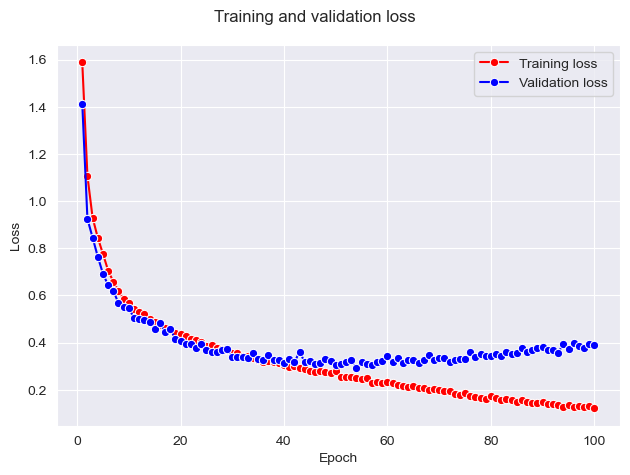

In [325]:
conv_nn.plot_loss()

The above clearly shows that the model begins overfitting on the noise at about 40 epochs

In [326]:
def predict(model, test_loader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    # Put model into evaluation mode
    model.eval()
    predictions = []
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        output = model(test_imgs)
        prediction = torch.max(output,1)[1]
        predictions.append(prediction.data.cpu().numpy())

    model.train()
    return np.concatenate(predictions)


In [327]:
# We load the early stopping model
saved_nn = CNN()
saved_nn.load_state_dict(torch.load('data/saved_model.pth'))


<All keys matched successfully>

In [328]:
# predicting
saved_nn_y_pred=predict(saved_nn, loaders['test'])
conv_y_pred = predict(conv_nn, loaders["test"])


# Comparing the two versions of the CNN

In [329]:
print("Early stopping CNN:\n",classification_report(y_true=y_test, 
                            y_pred=saved_nn_y_pred,
                            target_names=CLOTHING_TYPES.values()))
print()
print("Possibly overfitted CNN:\n",classification_report(y_true=y_test, 
                            y_pred=conv_y_pred,
                            target_names=CLOTHING_TYPES.values()))


Early stopping CNN:
               precision    recall  f1-score   support

 T-shirt/top       0.82      0.82      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.86      0.87      0.87      1000
       Dress       0.90      0.93      0.91      1000
       Shirt       0.73      0.72      0.72      1000

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


Possibly overfitted CNN:
               precision    recall  f1-score   support

 T-shirt/top       0.81      0.83      0.82      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.83      0.91      0.87      1000
       Dress       0.90      0.92      0.91      1000
       Shirt       0.77      0.68      0.72      1000

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      

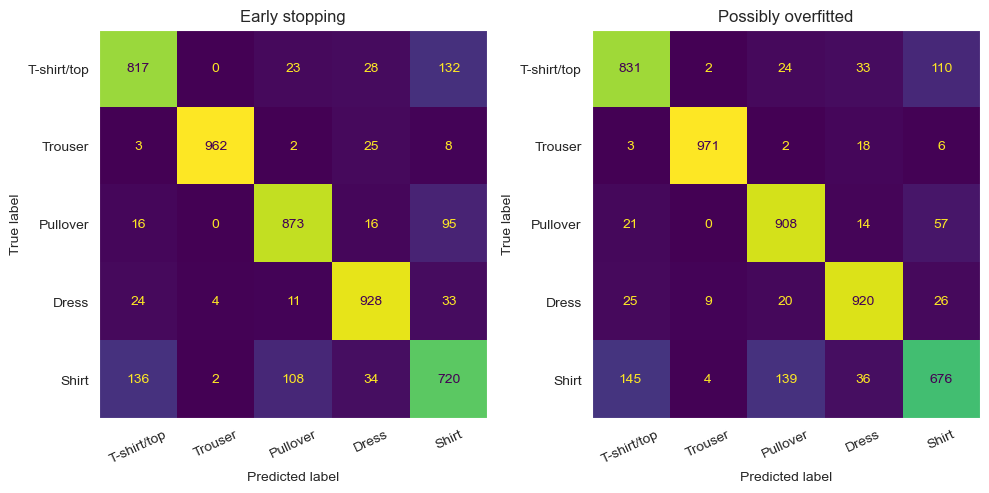

In [330]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=saved_nn_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax[0], xticks_rotation=25,colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=y_test, y_pred=conv_y_pred), 
                       display_labels=CLOTHING_TYPES.values()).plot(ax=ax[1], xticks_rotation=25, colorbar=False)

ax[0].grid(False)
ax[0].set_title("Early stopping")
ax[1].grid(False)
ax[1].set_title("Possibly overfitted")
fig.tight_layout()

We choose the early stopping method.

# Visualizing filters

In [331]:
def get_conv_layers(cnn):

    model_weights = []
    conv_layers = []
    model_children = list(cnn.children())


    for child in model_children:
        if type(child) == nn.Conv2d:
            model_weights.append(child.weight)
            conv_layers.append(child)
        elif type(child) == nn.Sequential:
            for grandchild in child:
                if type(grandchild) == nn.Conv2d:
                    model_weights.append(grandchild.weight)
                    conv_layers.append(grandchild)

    return conv_layers, model_weights
            

conv_layers, model_weights = get_conv_layers(conv_nn)
                

# filter shapes (conv layer sizes)
for weight, conv in zip(model_weights,conv_layers):
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")


CONV: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([6, 1, 5, 5])
CONV: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([16, 6, 5, 5])


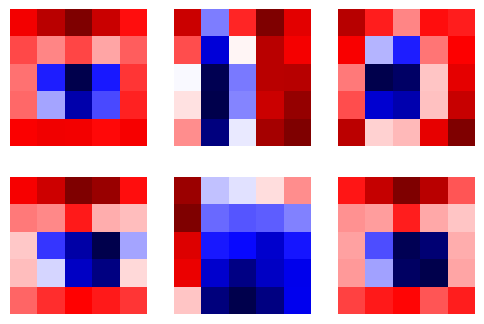

<Figure size 640x480 with 0 Axes>

In [332]:
# Visualizing first filters
cmap = plt.get_cmap("seismic_r")
plt.figure(figsize=(6,4))

for i, filter in enumerate(model_weights[0]):
    plt.subplot(2,3, i+1)
    plt.imshow(filter[0,:,:].detach().cpu().numpy(), cmap=cmap)
    plt.axis('off')
plt.show()
plt.tight_layout();

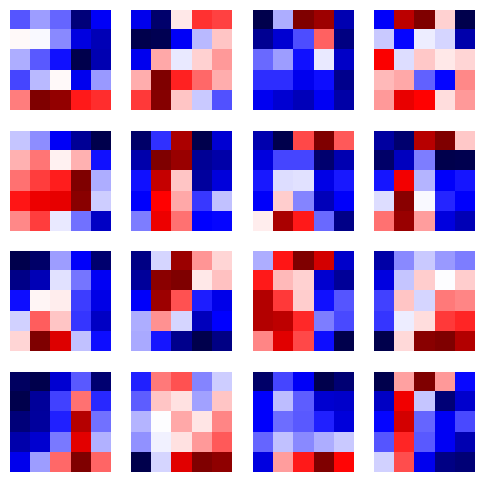

<Figure size 640x480 with 0 Axes>

In [333]:
# Visualizing second filters

plt.figure(figsize=(6,6))

for i, filter in enumerate(model_weights[1]):
    plt.subplot(4,4, i+1)
    plt.imshow(filter[0,:,:].detach().cpu().numpy(), cmap=cmap)
    plt.axis('off')
plt.show()
plt.tight_layout();

In [334]:
def plot_img_with_convolution(conv_layers,idx):
    cmap = plt.get_cmap("seismic_r")
    # Visualising feature maps
    example_img = to_tensor(np.float32(X_train[idx].reshape(28,28))).to(torch.device("mps" if torch.backends.mps.is_available() else "cpu"))

    # Create a mini model using only conv1

    model1 = nn.Sequential(conv_layers[0])

    output_conv1_convolution = model1(example_img)

    fig = plt.figure(figsize=(12,6))

    grid = gridspec.GridSpec(8, 16, figure=fig)

    # Creating the 2x3 subplot within the defined grid

    # left side (plots greyscale image)
    ax1 = fig.add_subplot(grid[2:6, :4])
    ax1.imshow(X_train[idx].reshape(28,28), cmap="grey")
    ax1.grid(False)
    ax1.set_title(f'Greyscale Image ({CLOTHING_TYPES[y_train[idx]]})')

    # Right side

    ax2 = fig.add_subplot(grid[:4, 4:8])
    ax2.imshow(output_conv1_convolution[0].detach().cpu().numpy(), cmap=cmap)
    ax2.grid(False)
    ax2.set_title('Filter 1')


    ax3 = fig.add_subplot(grid[:4, 8:12])
    ax3.imshow(output_conv1_convolution[1].detach().cpu().numpy(), cmap=cmap)
    ax3.grid(False)
    ax3.set_title('Filter 2')


    ax4 = fig.add_subplot(grid[:4, 12:16])
    ax4.imshow(output_conv1_convolution[2].detach().cpu().numpy(), cmap=cmap)
    ax4.grid(False)
    ax4.set_title('Filter 3')


    ax5 = fig.add_subplot(grid[4:, 4:8])
    ax5.imshow(output_conv1_convolution[3].detach().cpu().numpy(), cmap=cmap)
    ax5.grid(False)
    ax5.set_title('Filter 4')


    ax6 = fig.add_subplot(grid[4:, 8:12])
    ax6.imshow(output_conv1_convolution[4].detach().cpu().numpy(), cmap=cmap)
    ax6.grid(False)
    ax6.set_title('Filter 5')

    ax7 = fig.add_subplot(grid[4:, 12:16])
    ax7.imshow(output_conv1_convolution[5].detach().cpu().numpy(), cmap=cmap)
    ax7.grid(False)
    ax7.set_title('Filter 6')

    fig.tight_layout()



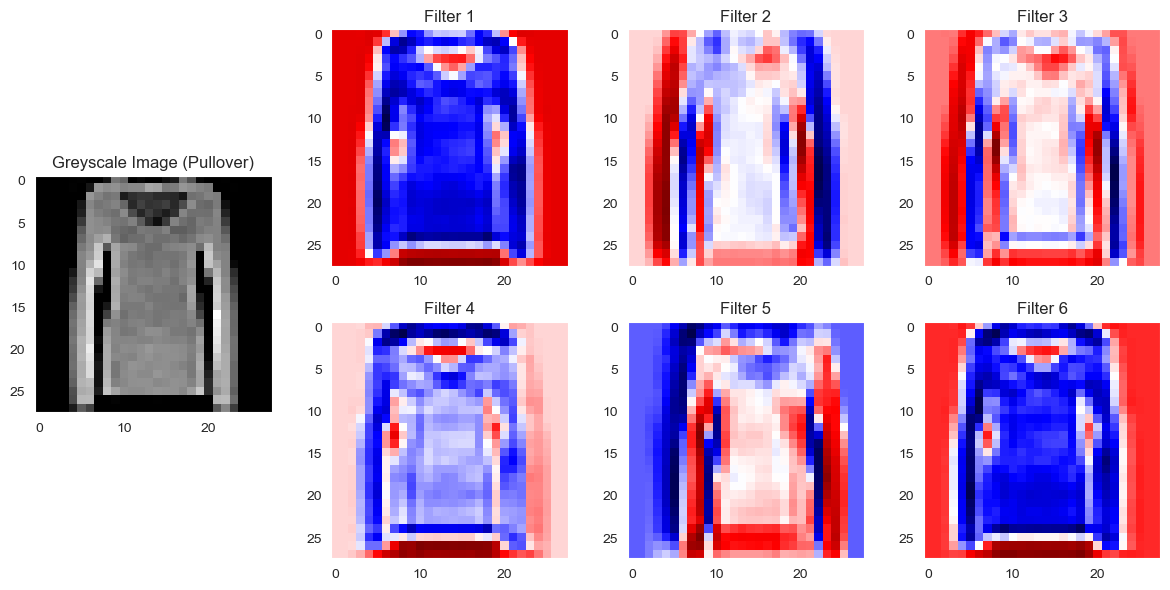

In [335]:
conv_layers_conv_nn, _ = get_conv_layers(conv_nn)
conv_layers_saved_nn, _ = get_conv_layers(saved_nn)

plot_img_with_convolution(conv_layers_conv_nn, 6)

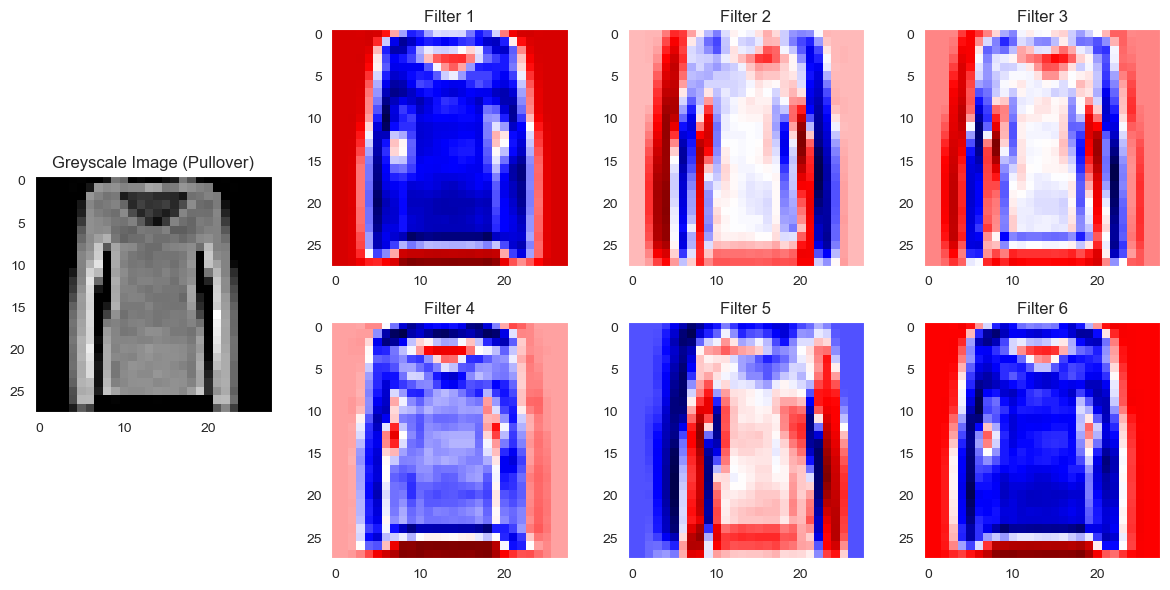

In [336]:
plot_img_with_convolution(conv_layers_saved_nn, 6)